In [187]:
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.coordinates as gc

from astroquery.gaia import Gaia
Gaia.login(user='apricewh', password='7Gy2^otQNj6FKz6')

In [2]:
gals = ascii.read('/Users/adrian/projects/lgcoordinates/data/NearbyGalaxies.dat')
gals_c = coord.SkyCoord(ra=gals['RA'], dec=gals['Dec'], unit=(u.hourangle, u.degree),
                        distance=coord.Distance(distmod=gals['distmod']))
# gals = gals[gals_c.distance < 50*u.kpc]
# gals_c = gals_c[gals_c.distance < 50*u.kpc]
len(gals_c)

110

In [3]:
glob = ascii.read('/Users/adrian/projects/uncluster/uncluster/data/harris_ascii.txt')
glob_c = coord.SkyCoord(ra=glob['ra']*u.deg, dec=glob['dec']*u.deg, 
                        distance=glob['dist']*u.kpc)
mask = (np.abs(glob_c.galactic.b) > 20*u.deg) #& (glob_c.distance < 50*u.kpc)
glob = glob[mask]
glob_c = glob_c[mask]
len(glob_c)

50

In [4]:
# tbl = Table()
# with h5py.File('../data/bhb.hdf5') as f:
#     cols = list(f['table/columns'].keys())
#     for c in cols:
#         tbl[c] = f['table/columns/{0}/data'.format(c)][:]
tbl = Table.read('../data/bhb_big.fits')

In [108]:
all_g = GaiaData(tbl)
c1 = coord.SkyCoord(ra=all_g.ra, dec=all_g.dec)

G_lim = coord.Distance(5*u.kpc).distmod - 1*u.mag

G = all_g.phot_g_mean_mag
bprp = all_g.phot_bp_mean_mag - all_g.phot_rp_mean_mag

g = all_g[(G > G_lim) & (bprp < 0*u.mag)]
G = g.phot_g_mean_mag
bprp = g.phot_bp_mean_mag - g.phot_rp_mean_mag

(19, 6)

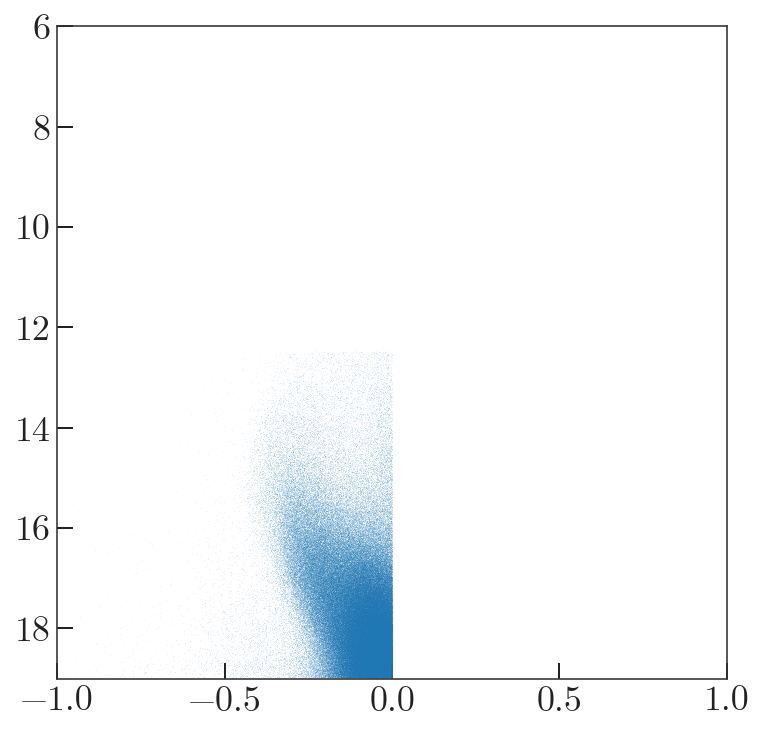

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bprp, G, marker=',', linestyle='none', alpha=0.1)
ax.set_xlim(-1, 1.)
ax.set_ylim(19, 6)

In [21]:
dist = coord.Distance(distmod=G - -1.*u.mag)

In [22]:
all_c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                       distance=dist,
                       pm_ra_cosdec=g.pmra,
                       pm_dec=g.pmdec,
                       radial_velocity=np.zeros(len(g))*u.km/u.s)

In [23]:
len(all_c)

306465

In [24]:
mag_c = all_c.transform_to(gc.MagellanicStream)
mag_mask = np.logical_not((mag_c.L.wrap_at(180*u.deg) < 10*u.deg) & 
                          (mag_c.L.wrap_at(180*u.deg) > -20*u.deg) & 
                          (mag_c.B < 15*u.deg) & (mag_c.B > -20*u.deg))

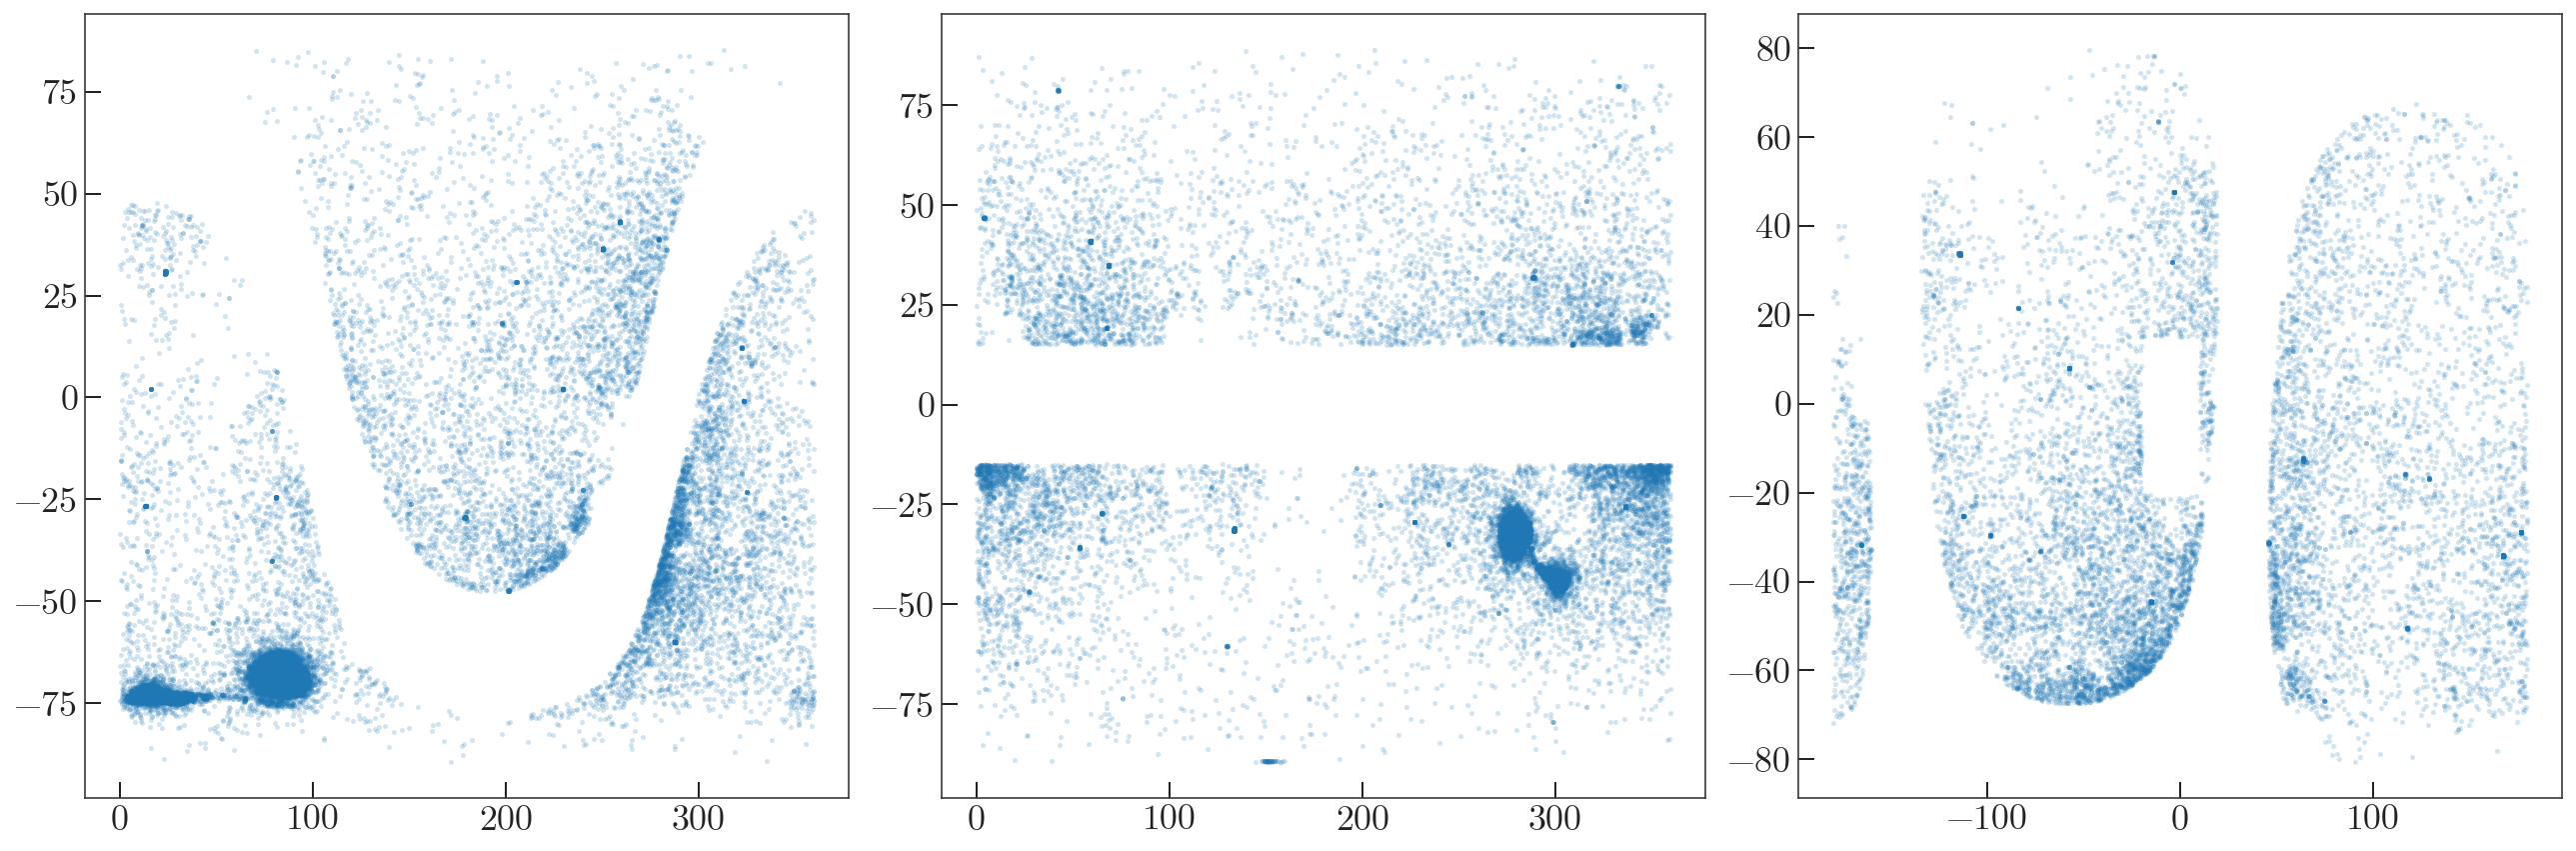

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].plot(all_c.ra.degree, all_c.dec.degree, marker='.', linestyle='none', alpha=0.2)
axes[1].plot(all_c.galactic.l.degree, all_c.galactic.b.degree, marker='.', linestyle='none', alpha=0.2)
axes[2].plot(mag_c.L.wrap_at(180*u.deg).degree[mag_mask], 
             mag_c.B.degree[mag_mask], 
             marker='.', linestyle='none', alpha=0.2)
fig.tight_layout()

In [26]:
mag_mask.sum()

10749

In [27]:
c = all_c[mag_mask]

---

In [41]:
from matplotlib.gridspec import GridSpec

(180, -180)

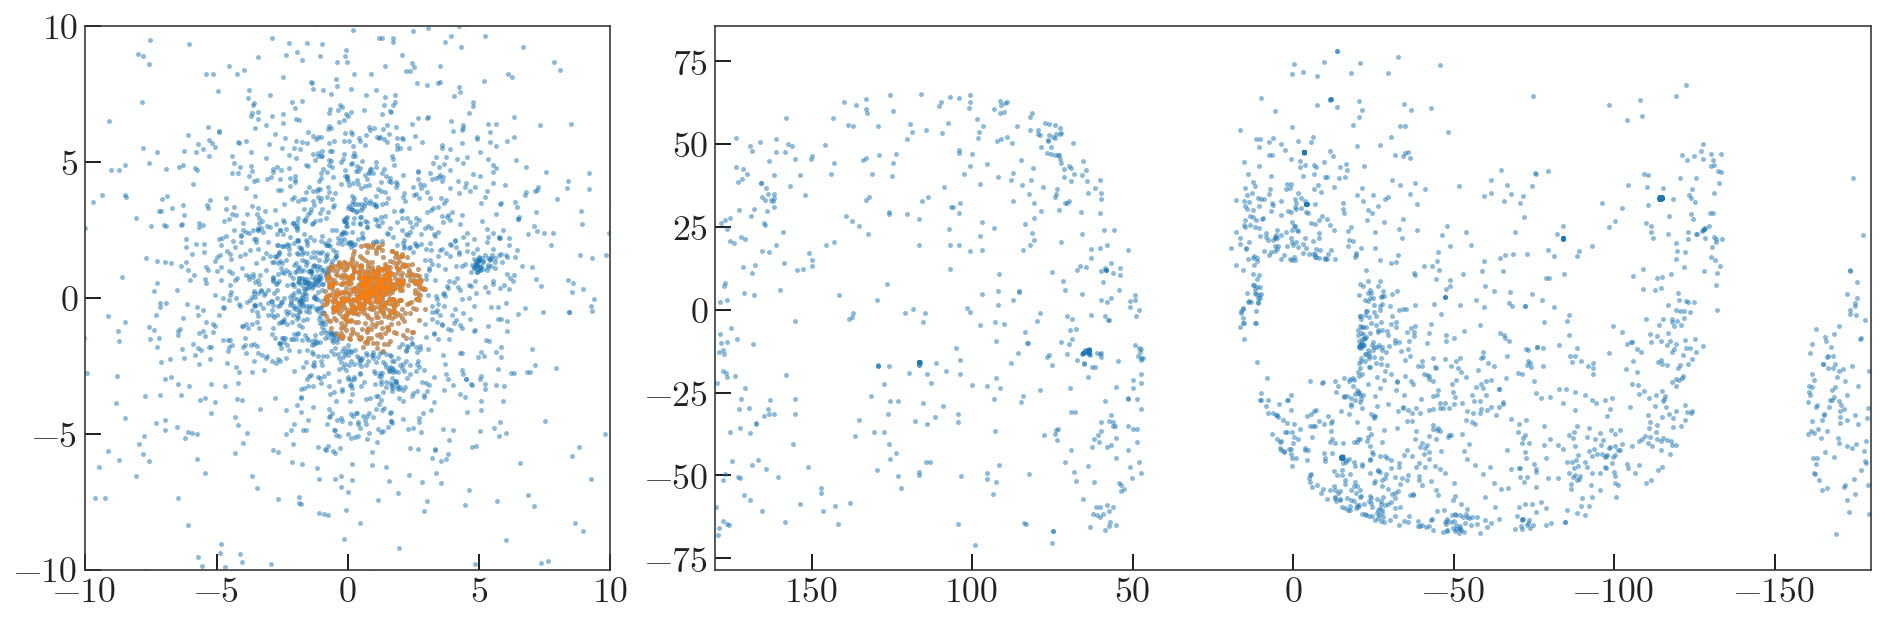

In [67]:
mag_c = gc.reflex_correct(c.transform_to(gc.MagellanicStream))

mag_mask = np.abs(mag_c.B) < 20*u.deg
# mag_pm_mask = (mag_c.pm_B < 1.6*u.mas/u.yr) & (mag_c.pm_B > -.5*u.mas/u.yr)
# mag_pm_mask = np.sqrt( (mag_c.pm_L_cosB - 1*u.mas/u.yr)**2 + (mag_c.pm_B - -3*u.mas/u.yr)**2 ) < 2*u.mas/u.yr
mag_pm_mask = np.sqrt( (mag_c.pm_L_cosB - 1*u.mas/u.yr)**2 + (mag_c.pm_B - 0*u.mas/u.yr)**2 ) < 2*u.mas/u.yr
                      
fig = plt.figure(figsize=(16, 5))

gs = GridSpec(1, 3)

ax = fig.add_subplot(gs[0])
ax.plot(mag_c.pm_L_cosB.value[mag_mask],
        mag_c.pm_B.value[mag_mask],
        marker='.', linestyle='none', alpha=0.5)

ax.plot(mag_c.pm_L_cosB.value[mag_mask & mag_pm_mask],
        mag_c.pm_B.value[mag_mask & mag_pm_mask],
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# ---

ax = fig.add_subplot(gs[1:])
ax.plot(mag_c.L.wrap_at(180*u.deg).degree[mag_pm_mask], 
        mag_c.B.degree[mag_pm_mask], 
        marker='.', linestyle='none', alpha=0.5)
ax.set_xlim(180, -180)

---

In [125]:
idx1, idx2, sep, _ = coord.search_around_sky(c, c, seplimit=5*u.deg)

In [126]:
dpm = np.sqrt((c[idx1].pm_ra_cosdec - c[idx2].pm_ra_cosdec)**2 + (c[idx1].pm_dec - c[idx2].pm_dec)**2)

In [127]:
# pm_h = (20*u.km/u.s / (c[idx1].distance)).to(u.mas/u.yr, u.dimensionless_angles())
# pm_h = (10*u.km/u.s / (25*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())
pm_h = 0.5*u.mas/u.yr

In [128]:
pm_mask = (dpm < pm_h) & (dpm > 0*u.mas/u.yr)
pm_mask.sum()

24958

In [129]:
pm_idx1 = idx1[pm_mask]
pm_idx2 = idx2[pm_mask]

In [211]:
N_gtr_3 = 0
mean_c = []
all_idx = []
for i1 in np.unique(pm_idx1):
    i2s = pm_idx2[pm_idx1 == i1]
    
    if len(i2s) < 5:
        continue
        
    N_gtr_3 += 1
    
    mean_c.append([np.mean(c[i2s].ra.degree),
                   np.mean(c[i2s].dec.degree),
                   np.mean(c[i2s].pm_ra_cosdec.value),
                   np.mean(c[i2s].pm_dec.value)])
    all_idx.append(i2s)

mean_c = np.array(mean_c)
mean_c = coord.SkyCoord(ra=mean_c[:,0]*u.deg, dec=mean_c[:,1]*u.deg,
                        pm_ra_cosdec=mean_c[:,2]*u.mas/u.yr, 
                        pm_dec=mean_c[:,3]*u.mas/u.yr)
all_idx = np.array(all_idx)

Text(0,0.5,'$b$ [deg]')

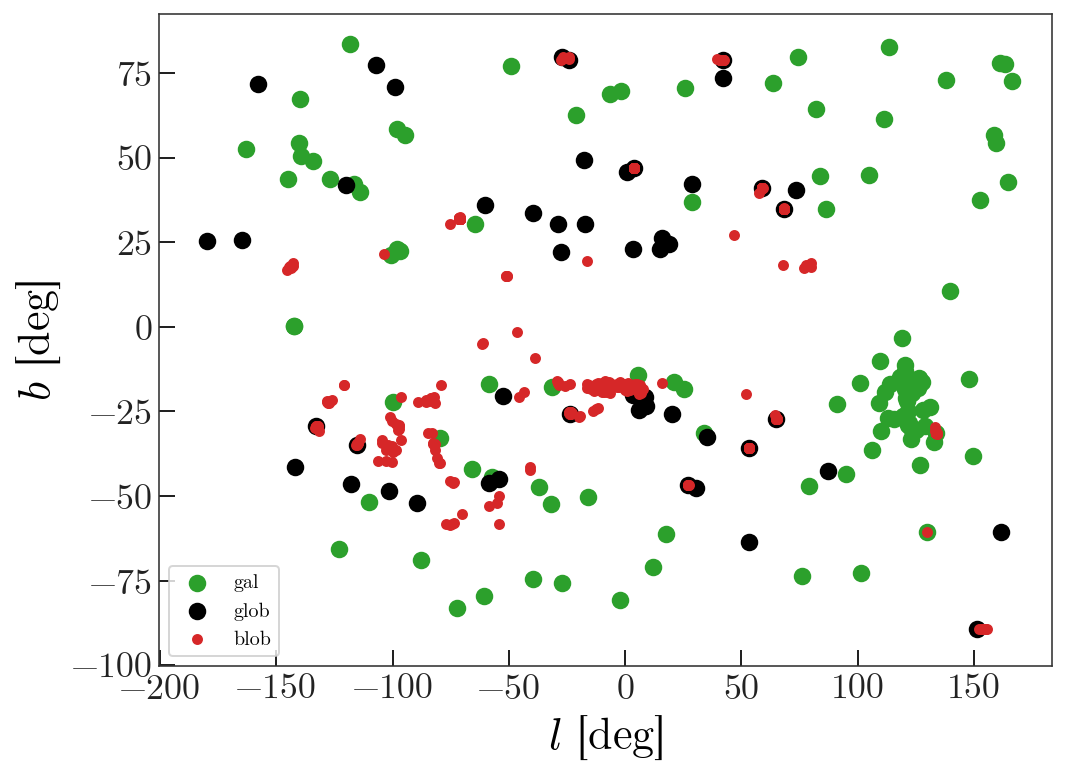

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(gals_c.galactic.l.wrap_at(180*u.deg),
           gals_c.galactic.b, marker='o', s=60, 
           color='tab:green', zorder=-10, label='gal')

ax.scatter(glob_c.galactic.l.wrap_at(180*u.deg),
           glob_c.galactic.b, marker='o', s=60, 
           color='k', zorder=-10, label='glob')

ax.scatter(mean_c.galactic.l.wrap_at(180*u.deg), 
           mean_c.galactic.b, 
           s=20, color='tab:red', label='blob')

ax.legend(loc='lower left')

ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')

In [213]:
idx, sep, _ = mean_c.match_to_catalog_sky(glob_c)
unknown_mask = sep > 0.5*u.deg

idx, sep, _ = mean_c.match_to_catalog_sky(gals_c)
unknown_mask &= sep > 0.5*u.deg

unknown_mask.sum()

296

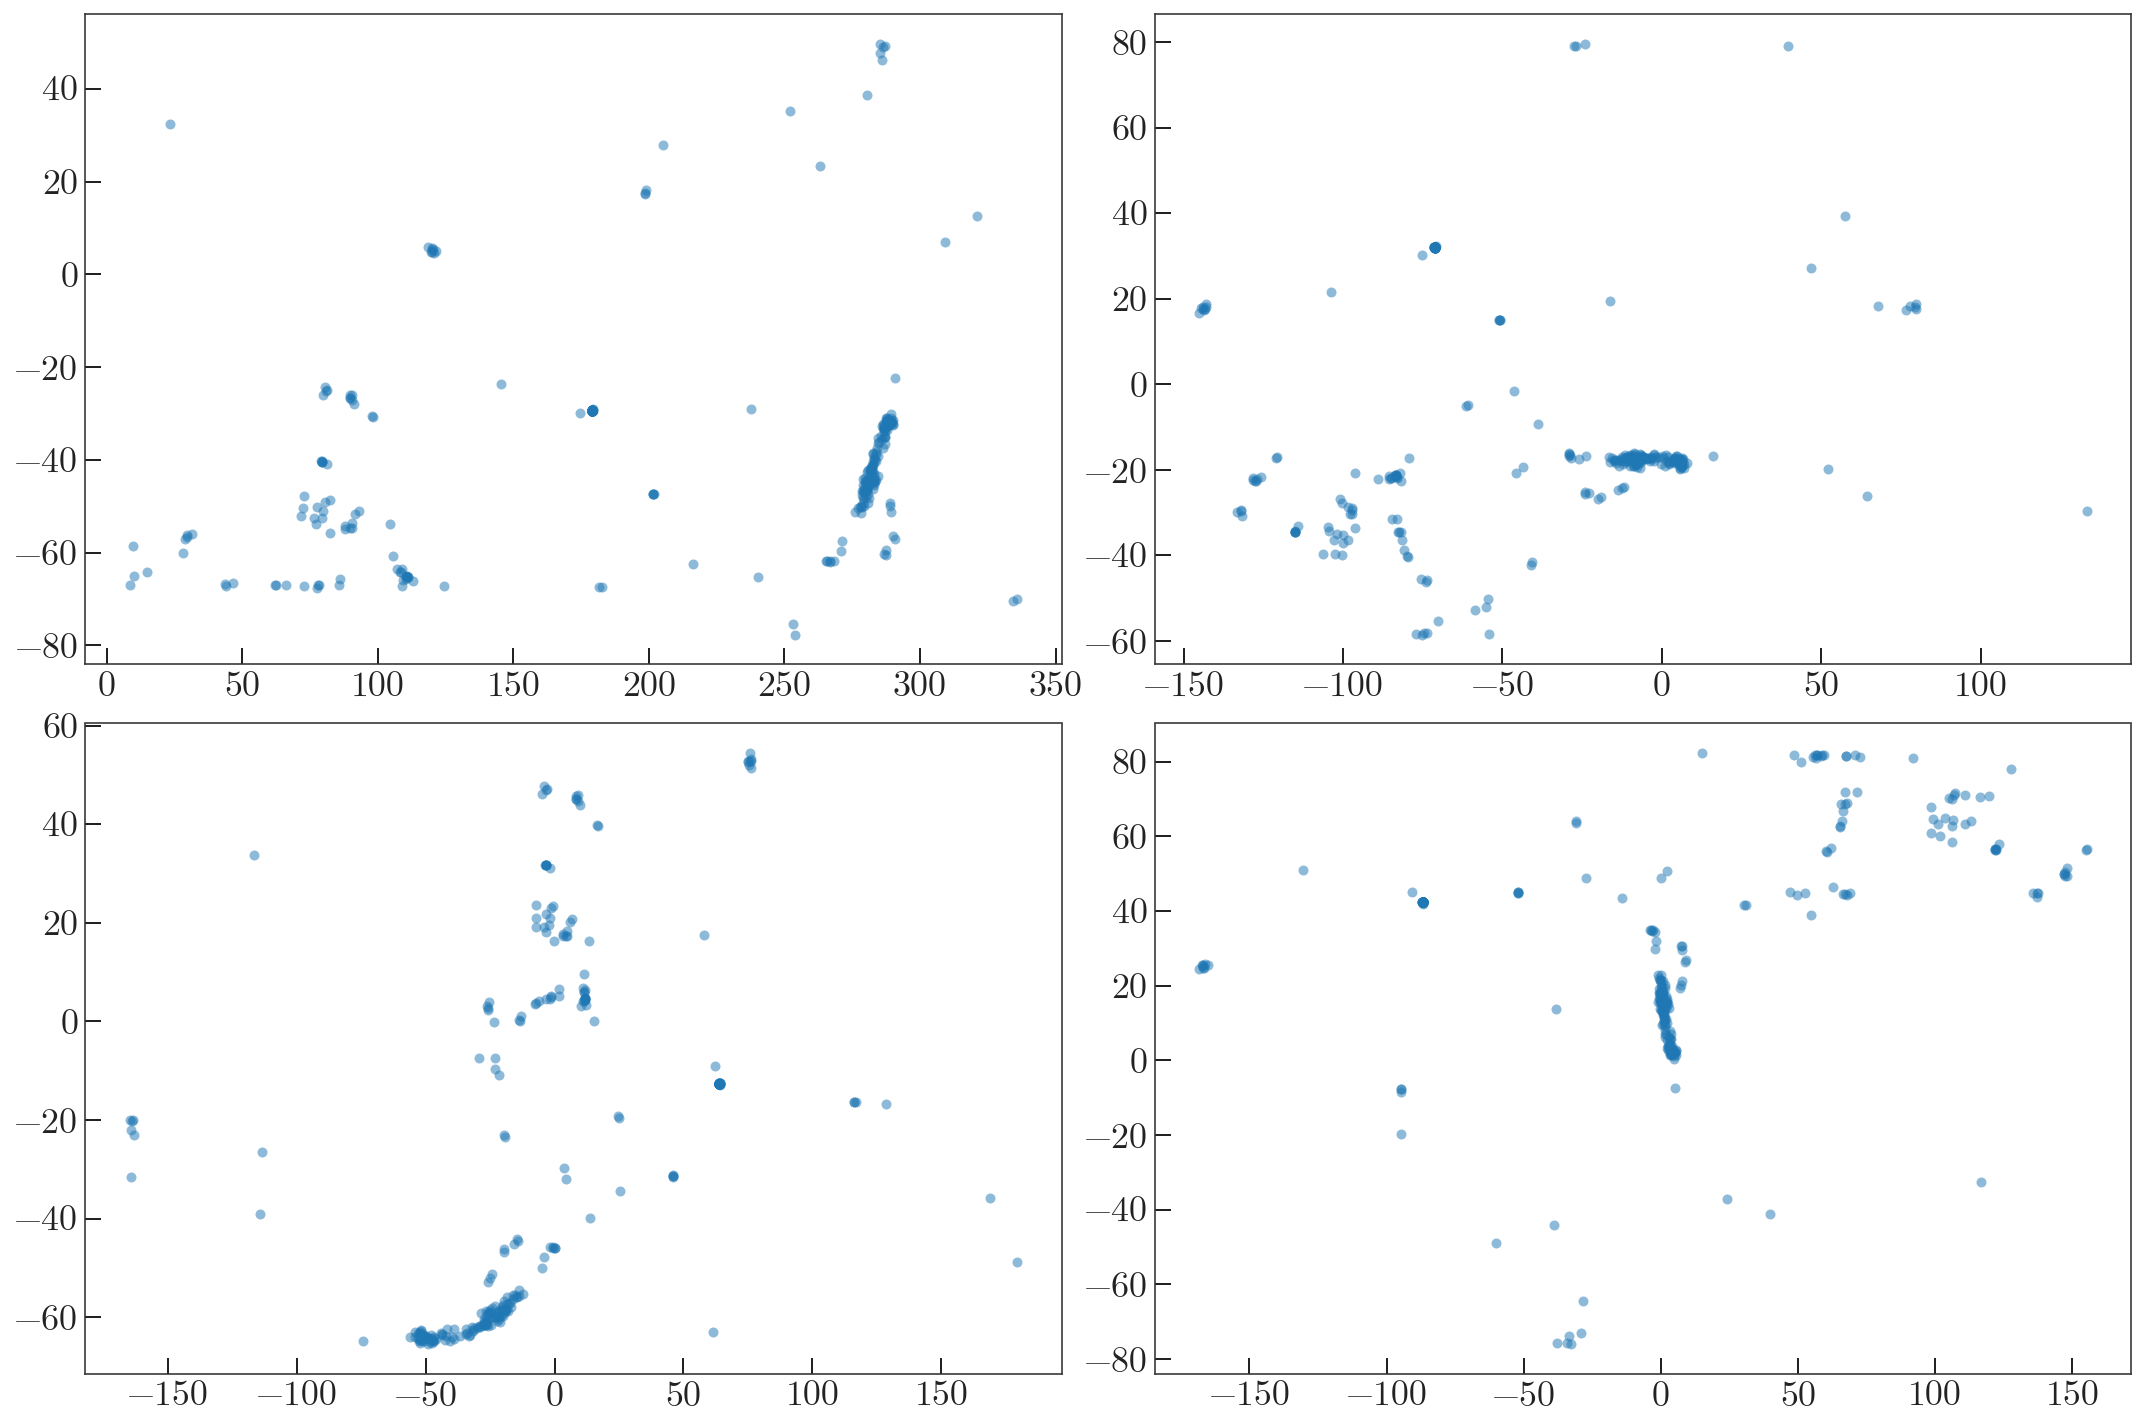

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
style = dict(marker='o', linestyle='none', 
             alpha=0.5, color='tab:blue')

axes[0,0].plot(mean_c.ra[unknown_mask], 
               mean_c.dec[unknown_mask], **style)

axes[0,1].plot(mean_c.galactic.l.wrap_at(180*u.deg)[unknown_mask], 
               mean_c.galactic.b[unknown_mask], **style)

_mag = mean_c.transform_to(gc.MagellanicStream)
axes[1,0].plot(_mag.L.wrap_at(180*u.deg).degree[unknown_mask], 
               _mag.B.degree[unknown_mask], **style)

_sag = mean_c.transform_to(gc.Sagittarius)
axes[1,1].plot(_sag.Lambda.wrap_at(180*u.deg).degree[unknown_mask], 
               _sag.Beta.degree[unknown_mask], **style)

fig.tight_layout()

In [163]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

In [214]:
X = np.vstack((mean_c[unknown_mask].ra.degree, 
               mean_c[unknown_mask].dec.degree,
               mean_c[unknown_mask].pm_ra_cosdec.value*10,
               mean_c[unknown_mask].pm_dec.value*10)).T

In [229]:
Clustering = AgglomerativeClustering
# Clustering = KMeans

n_clusters = np.arange(35, 85)
score = np.zeros(len(n_clusters))
for i, n in enumerate(n_clusters):
    clf = Clustering(n_clusters=n)
    score[i] = silhouette_score(X, clf.fit_predict(X))
    
# clf = Clustering(n_clusters=n_clusters[score.argmax()])
clf = Clustering(n_clusters=65)
cls = clf.fit_predict(X)

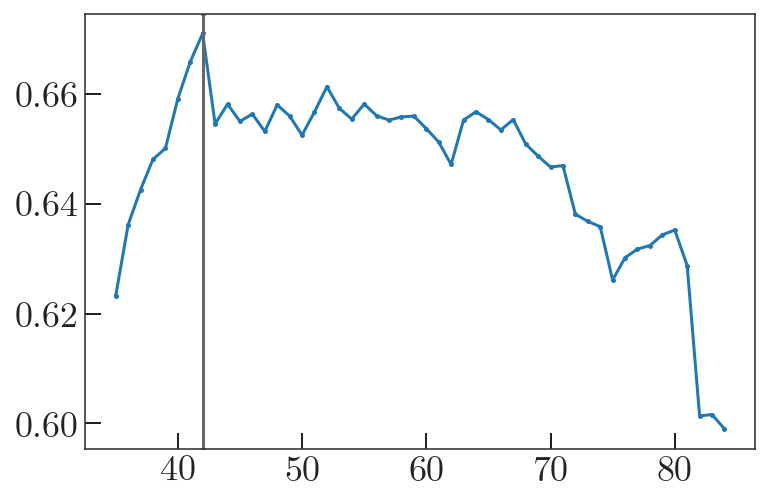

In [230]:
plt.plot(n_clusters, score)
plt.axvline(n_clusters[score.argmax()])

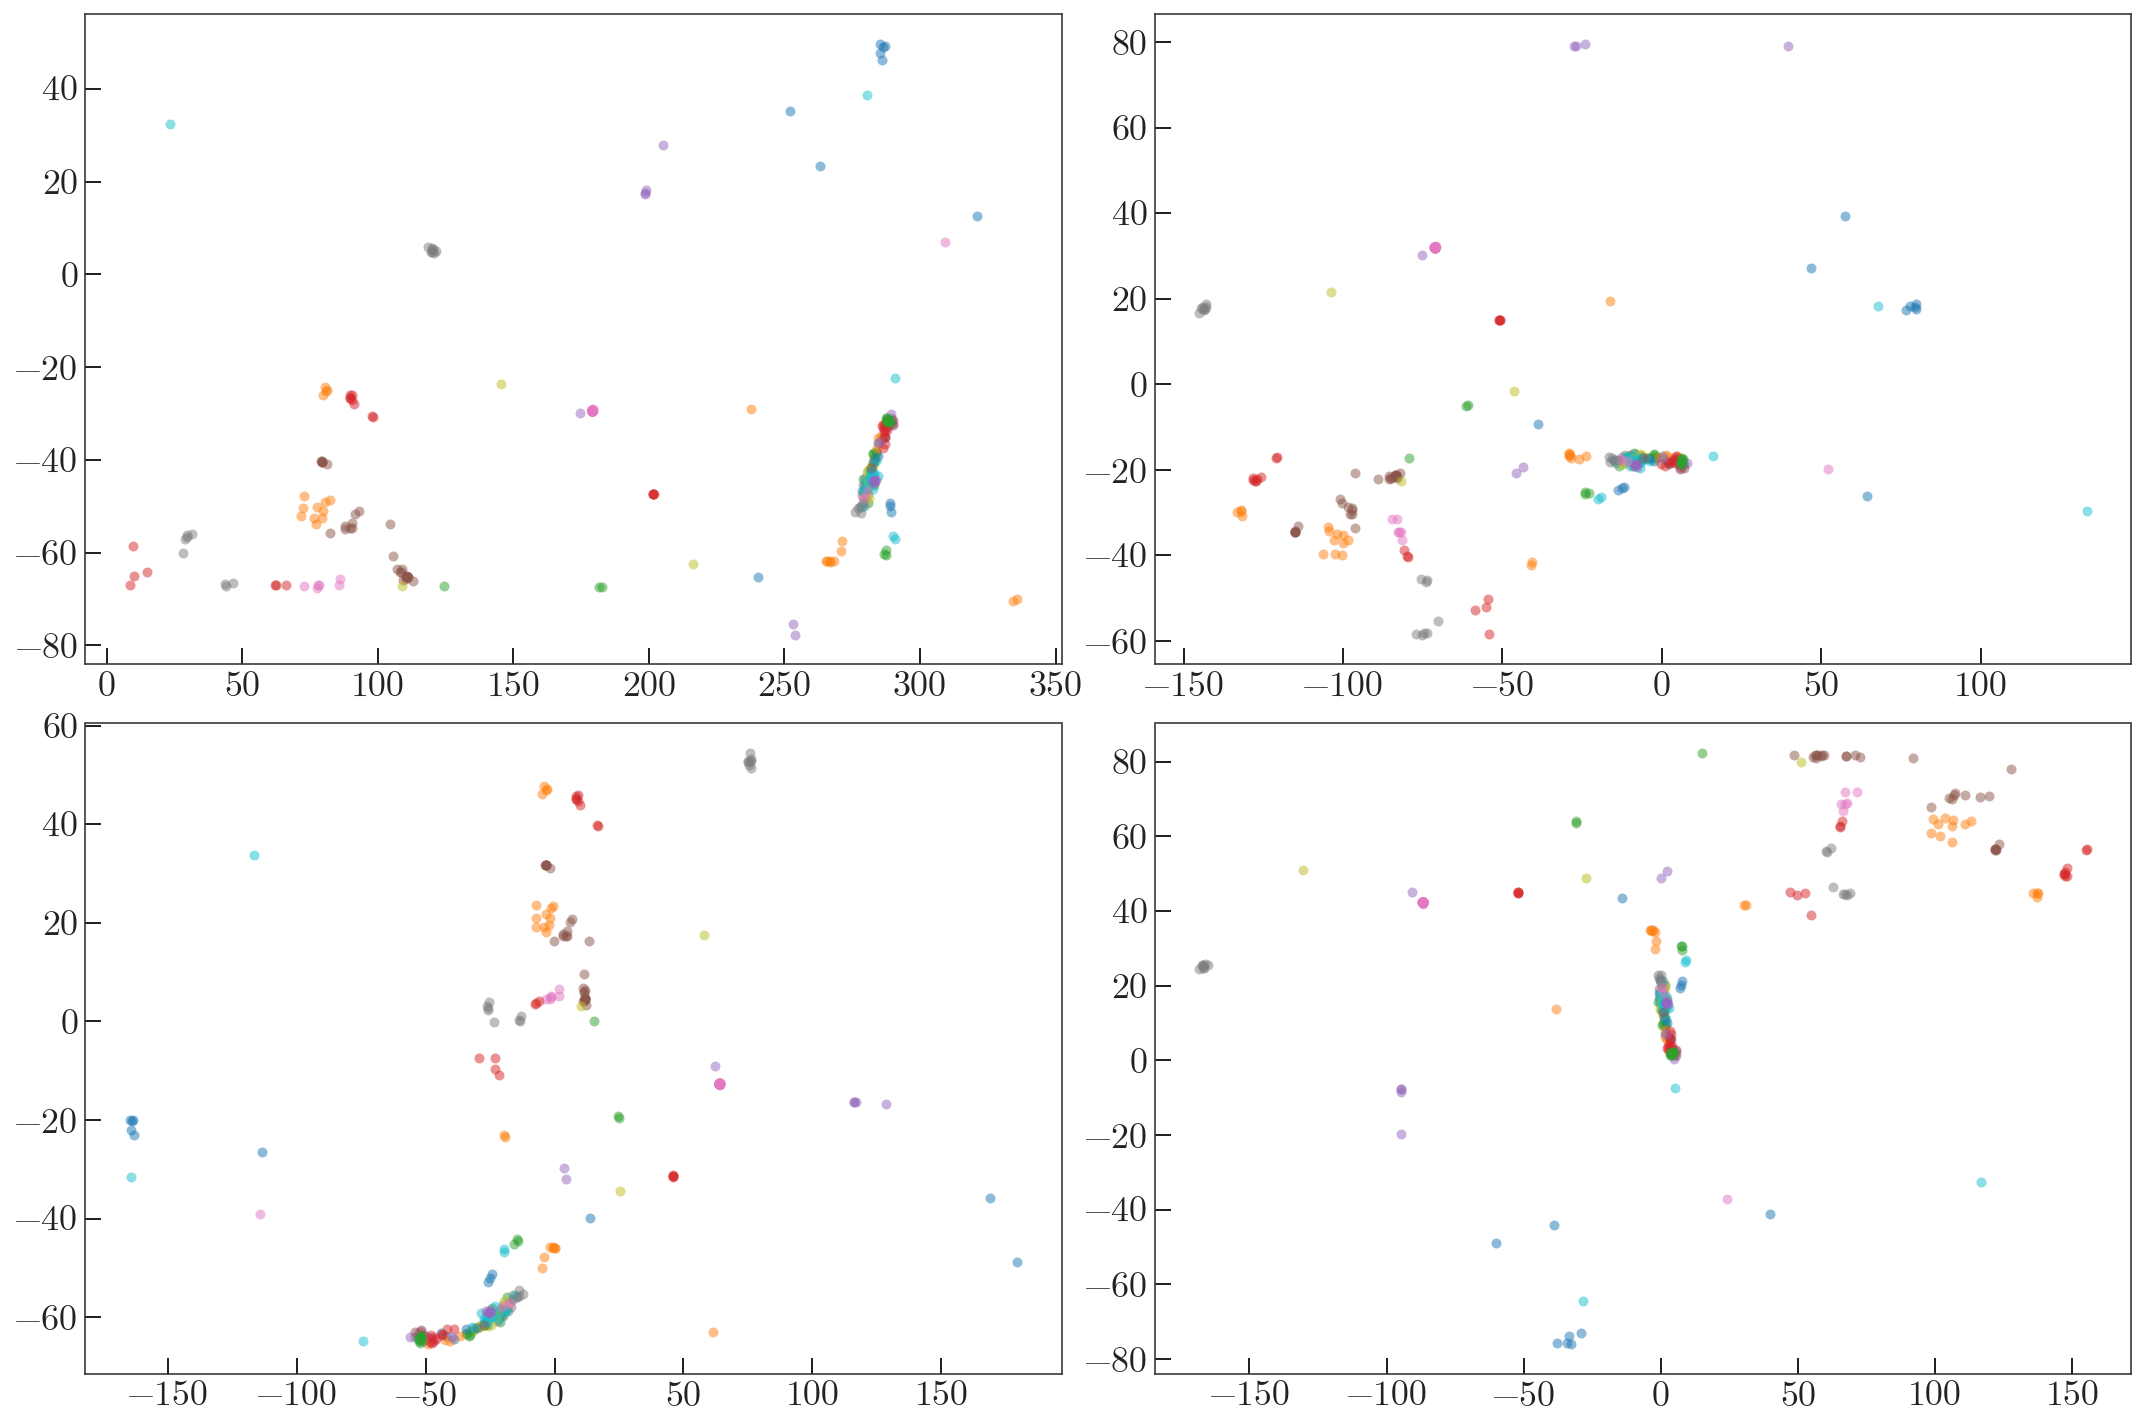

In [242]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
style = dict(marker='o', linestyle='none', alpha=0.5)

for i in np.sort(np.unique(cls)):
    axes[0,0].plot(mean_c.ra[unknown_mask][cls == i], 
                   mean_c.dec[unknown_mask][cls == i], **style)

    axes[0,1].plot(mean_c.galactic.l.wrap_at(180*u.deg)[unknown_mask][cls == i], 
                   mean_c.galactic.b[unknown_mask][cls == i], **style)

    _mag = mean_c.transform_to(gc.MagellanicStream)
    axes[1,0].plot(_mag.L.wrap_at(180*u.deg).degree[unknown_mask][cls == i], 
                   _mag.B.degree[unknown_mask][cls == i], **style)

    _sag = mean_c.transform_to(gc.Sagittarius)
    axes[1,1].plot(_sag.Lambda.wrap_at(180*u.deg).degree[unknown_mask][cls == i], 
                   _sag.Beta.degree[unknown_mask][cls == i], **style)

fig.tight_layout()

In [243]:
cls_to_idx2 = dict()
for i in np.unique(cls):
    cls_to_idx2[i] = np.unique(np.concatenate(all_idx[unknown_mask][cls == i]))

In [244]:
bhb_fn_fmt = '../data/bhb-group{0}.fits'

for group_i, i2 in cls_to_idx2.items():
    if len(i2) <= 16 and np.mean(c[i2].dec.degree) > -28:
        ra, dec = np.mean(c[i2].ra.degree), np.mean(c[i2].dec.degree)
        print(group_i, len(i2), ra, dec,
              np.mean(c[i2].galactic.l.degree), np.mean(c[i2].galactic.b.degree))
        
        bhb_fn = bhb_fn_fmt.format(group_i)
        break

0 11 257.09279428134596 29.837358111063168 52.72065071737191 33.8271126542472


In [234]:
q_fmt ='''SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.radial_velocity, 
gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, 
ps1.g_mean_psf_mag, ps1.r_mean_psf_mag, ps1.i_mean_psf_mag, ps1.z_mean_psf_mag, ps1.y_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) > -1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', {0}, {1}, {2})) = 1 AND
    (pmra > -15) AND (pmra < 15) AND 
    (pmdec > -15) AND (pmdec < 15) 
'''

In [235]:
job = Gaia.launch_job_async(q_fmt.format(ra, dec, 1.5))

Launched query: 'SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.radial_velocity, 
gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, 
ps1.g_mean_psf_mag, ps1.r_mean_psf_mag, ps1.i_mean_psf_mag, ps1.z_mean_psf_mag, ps1.y_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) > -1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', 257.09279428134596, 29.837358111063168, 1.5)) = 1 AND
    (pmra > -15) AND (pmra < 15) AND 
    (pmdec > -15) AND (pmdec < 15) 
'
Retrieving async. results...


Query finished.


In [236]:
tbl = job.get_results()

In [237]:
len(tbl)

19676

In [238]:
# tbl.write(bhb_fn)

In [239]:
group_g = GaiaData(tbl)

Text(0,0.5,'pmdec')

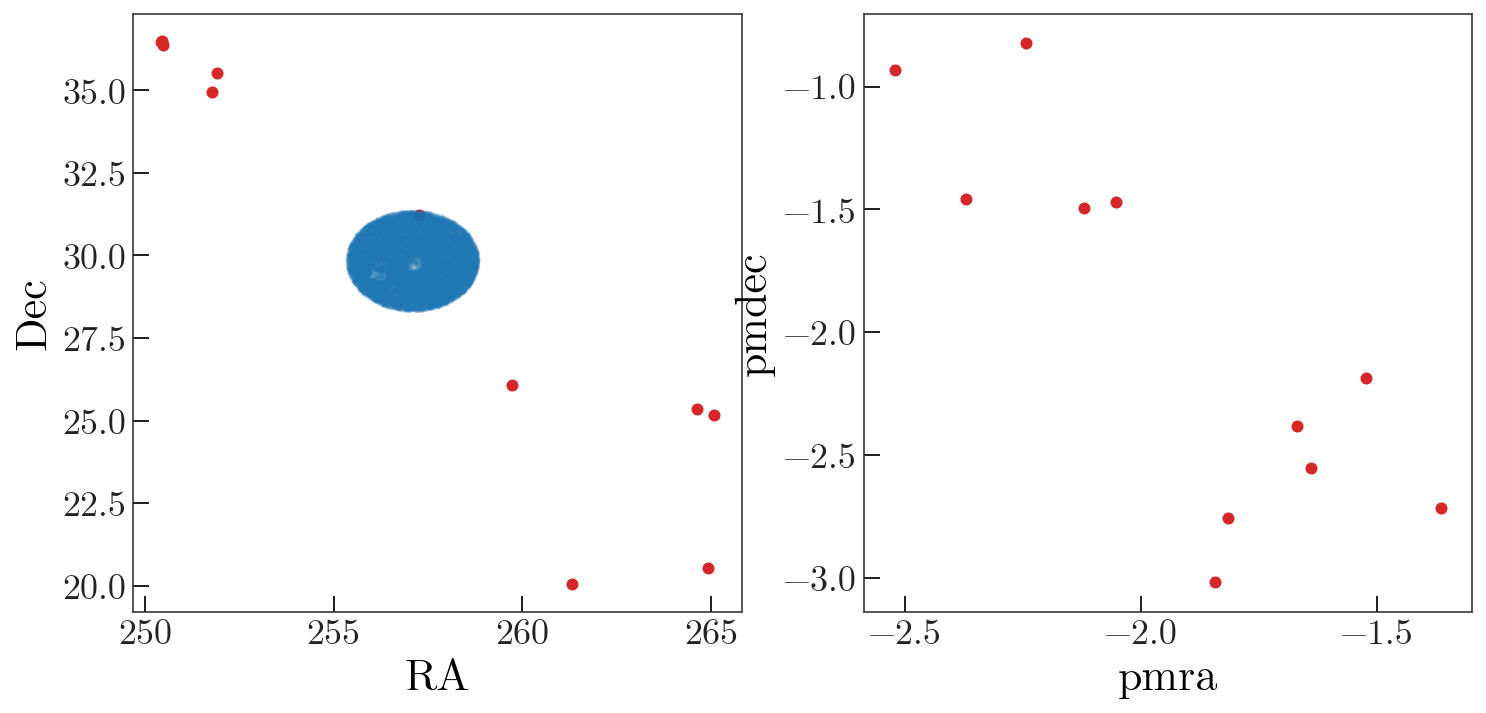

In [240]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].scatter(c[cls_to_idx2[group_i]].ra, 
                c[cls_to_idx2[group_i]].dec, 
                marker='o', color='tab:red')
axes[0].plot(group_g.ra, group_g.dec,
             marker='.', linestyle='none', alpha=0.1)
# _x, _y = (np.mean(c[cls_to_idx2[group_i]].ra.degree), 
#           np.mean(c[cls_to_idx2[group_i]].dec.degree))
# axes[0].set_xlim(_x - 1, _x + 1)
# axes[0].set_ylim(_y - 1, _y + 1)
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')

axes[1].scatter(c[cls_to_idx2[group_i]].pm_ra_cosdec, 
                c[cls_to_idx2[group_i]].pm_dec, 
                marker='o', color='tab:red')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

(19.5, 10)

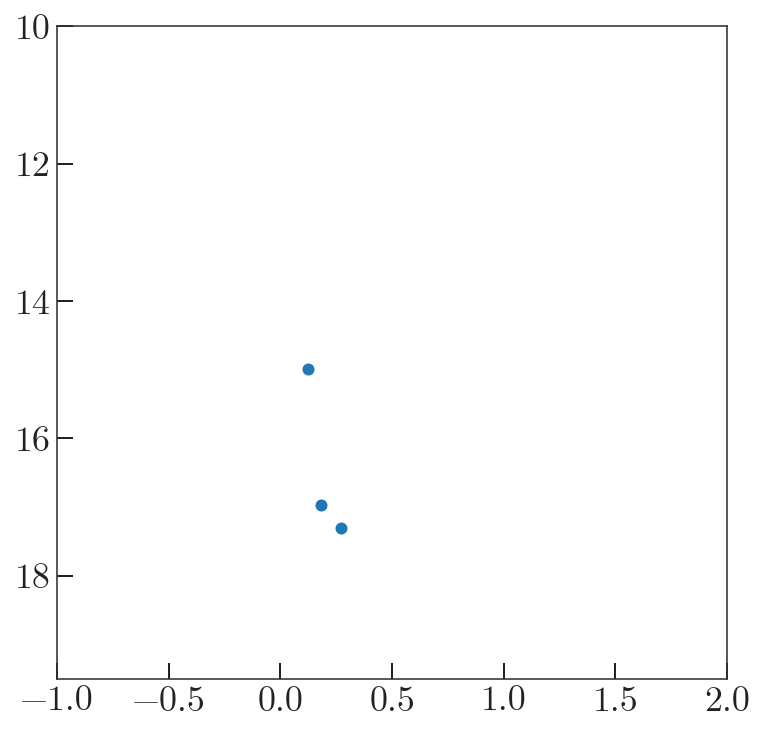

In [179]:
plt.figure(figsize=(6, 6))
plt.scatter(g[mag_mask][cls_to_idx2[group_i]].bp_rp, 
            g[mag_mask][cls_to_idx2[group_i]].phot_g_mean_mag)
plt.xlim(-1, 2)
plt.ylim(19.5, 10)

In [189]:
pmra = np.mean(c[cls_to_idx2[group_i]].pm_ra_cosdec)
pmdec = np.mean(c[cls_to_idx2[group_i]].pm_dec)
group_pm_mask = np.sqrt((group.pmra - pmra)**2 + (group.pmdec - pmdec)**2) < 0.65*u.mas/u.yr

Text(0,0.5,'pmdec')

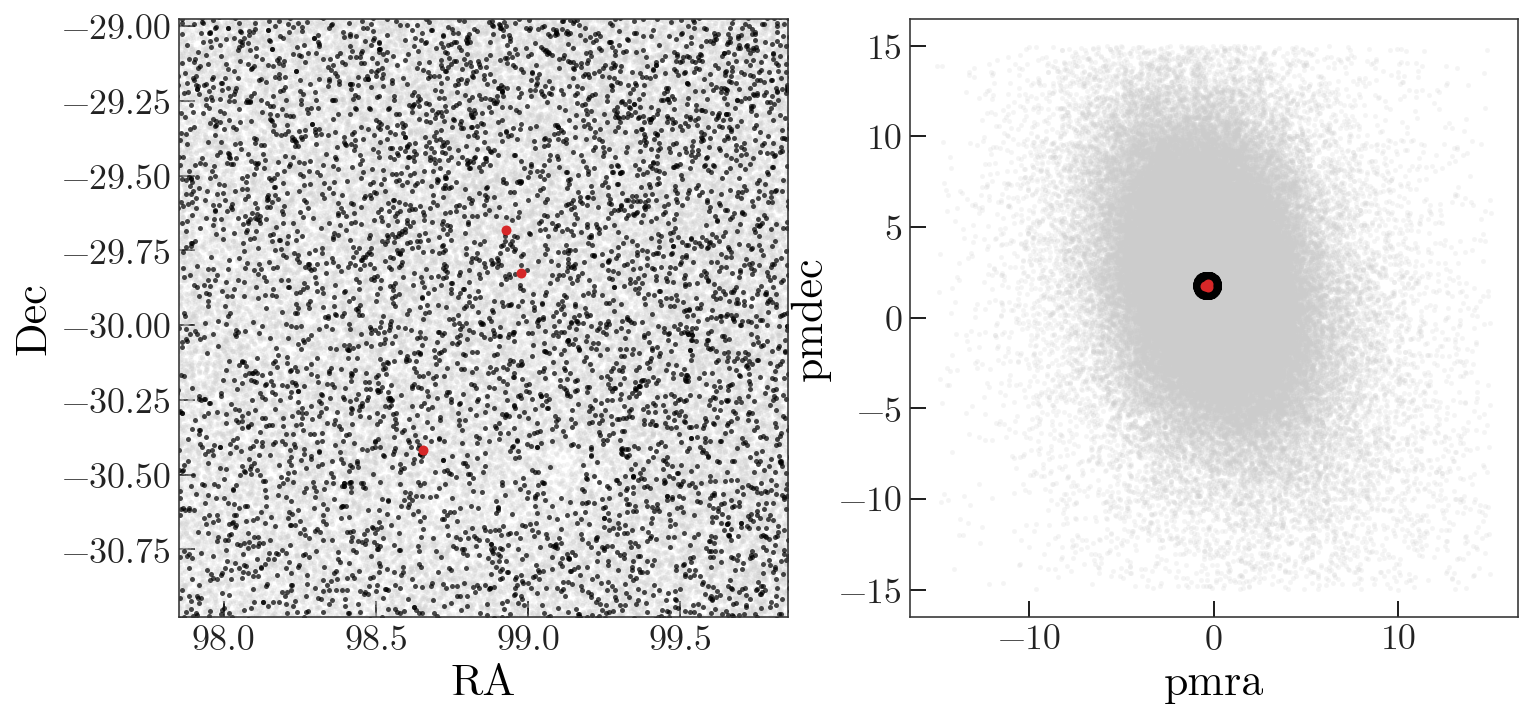

In [190]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].plot(group.ra, group.dec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[0].plot(group.ra[group_pm_mask], group.dec[group_pm_mask], marker='.', alpha=0.7, color='k', linestyle='none')
axes[0].plot(c[cls_to_idx2[group_i]].ra, c[cls_to_idx2[group_i]].dec, marker='o', color='tab:red', linestyle='none')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
axes[0].set_xlim(_x - 1, _x + 1)
axes[0].set_ylim(_y - 1, _y + 1)
axes[0].scatter(gals_c.ra.degree, gals_c.dec.degree)

axes[1].plot(group.pmra, group.pmdec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[1].plot(group.pmra[group_pm_mask], group.pmdec[group_pm_mask], marker='.', alpha=0.2, color='k', linestyle='none')
axes[1].plot(c[cls_to_idx2[group_i]].pm_ra_cosdec, c[cls_to_idx2[group_i]].pm_dec, marker='o', color='tab:red', linestyle='none')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

In [191]:
c[cls_to_idx2[group_i]].transform_to(coord.Galactic)

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(238.59469745, -16.20454543, 18.21264839),
     (239.05563443, -16.68724117, 15.62522221),
     (238.43969885, -16.1892233 ,  6.30418921)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-1.81211532, 0.20936663, 9.68388220e-14),
     (-1.70772807, 0.36407368, 9.15758425e-14),
     (-1.84931472, 0.42259686, 2.36834076e-14)]>

Text(0,0.5,'$G$')

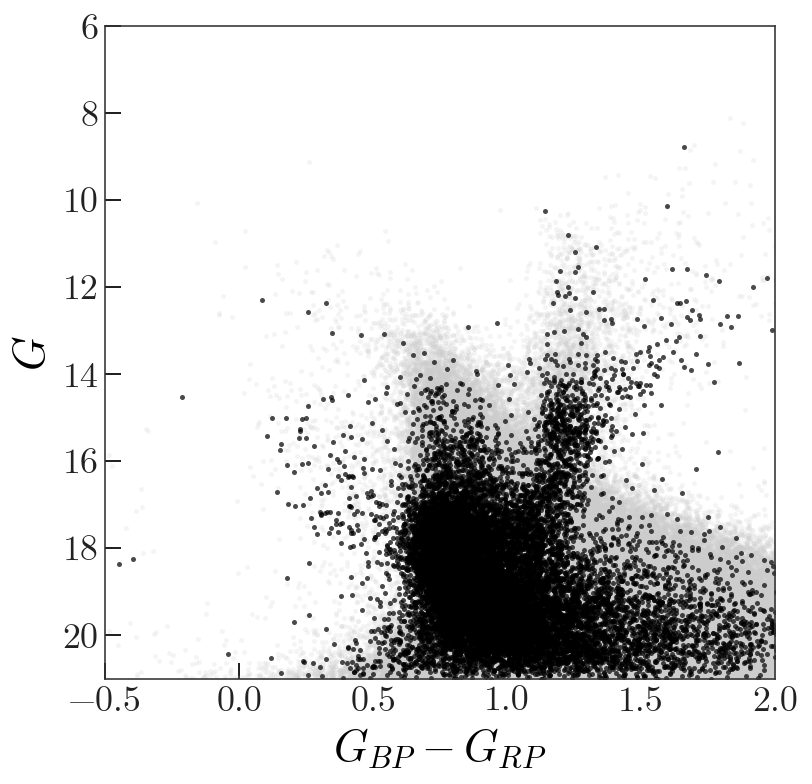

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(group.bp_rp, group.phot_g_mean_mag, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
ax.plot(group.bp_rp[group_pm_mask], group.phot_g_mean_mag[group_pm_mask],
        marker='.', alpha=0.7, color='k', linestyle='none')

ax.set_xlim(-0.5, 2.)
ax.set_ylim(21, 6)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$G$')

In [195]:
cmd_mask = (group.phot_g_mean_mag < 18*u.mag) & (group.bp_rp > 1.05*u.mag) & (group.bp_rp < 1.5*u.mag)
# cmd_mask = (group.phot_g_mean_mag < 19*u.mag) & (group.bp_rp < 0.6*u.mag)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0,0.5,'pmdec')

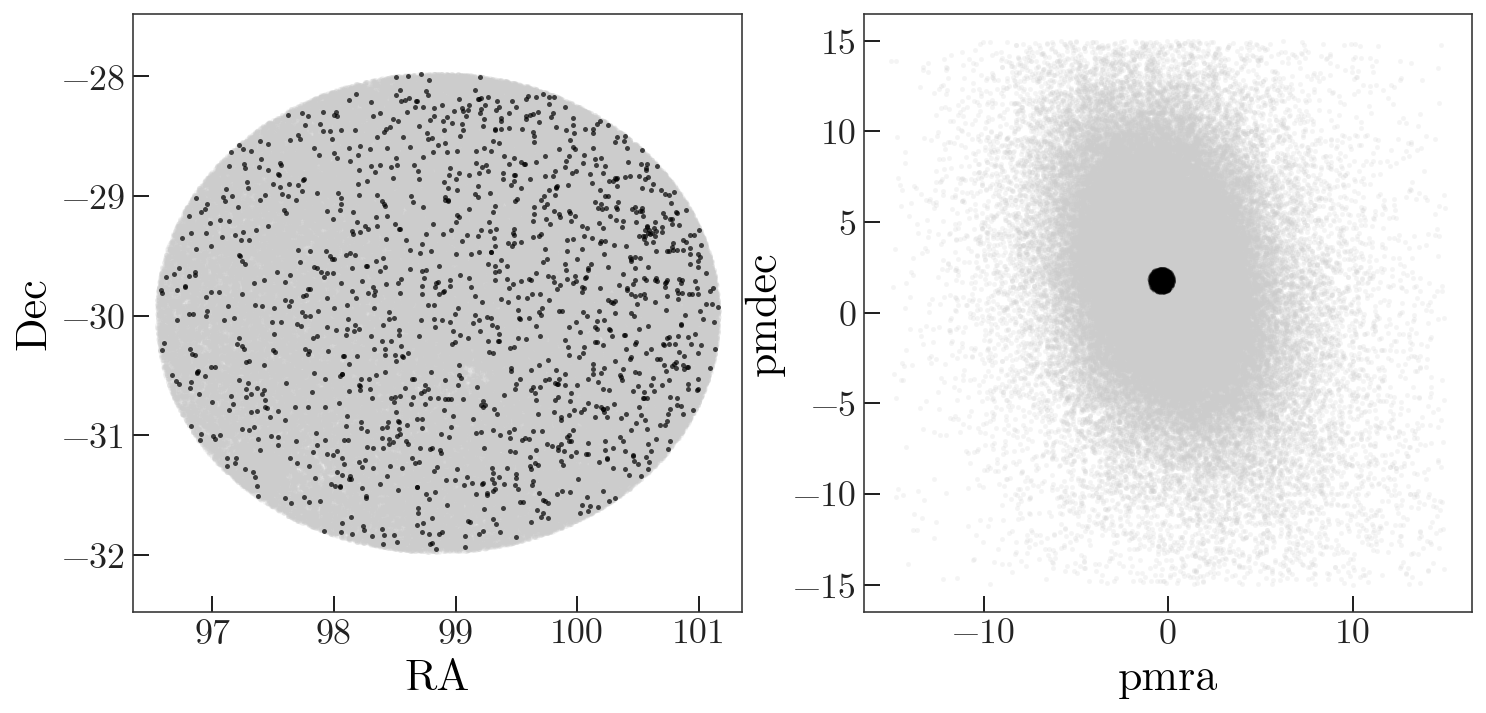

In [200]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].plot(group.ra, group.dec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[0].plot(group.ra[group_pm_mask&cmd_mask], group.dec[group_pm_mask&cmd_mask], 
             marker='.', alpha=0.7, color='k', linestyle='none')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
axes[0].set_xlim(_x - 2.5, _x + 2.5)
axes[0].set_ylim(_y - 2.5, _y + 2.5)
# axes[0].set_xlim(100, _x + 2)
# axes[0].set_ylim(-30, -28.5)
axes[0].scatter(gals_c.ra.degree, gals_c.dec.degree)

axes[1].plot(group.pmra, group.pmdec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[1].plot(group.pmra[group_pm_mask&cmd_mask], group.pmdec[group_pm_mask&cmd_mask], 
             marker='.', alpha=0.2, color='k', linestyle='none')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

In [201]:
derp = coord.SkyCoord(ra=100.6*u.deg, dec=-29.3*u.deg)
derp_mask = derp.separation(coord.SkyCoord(ra=group.ra, dec=group.dec)) < 0.12*u.deg

Text(0,0.5,'pmdec')

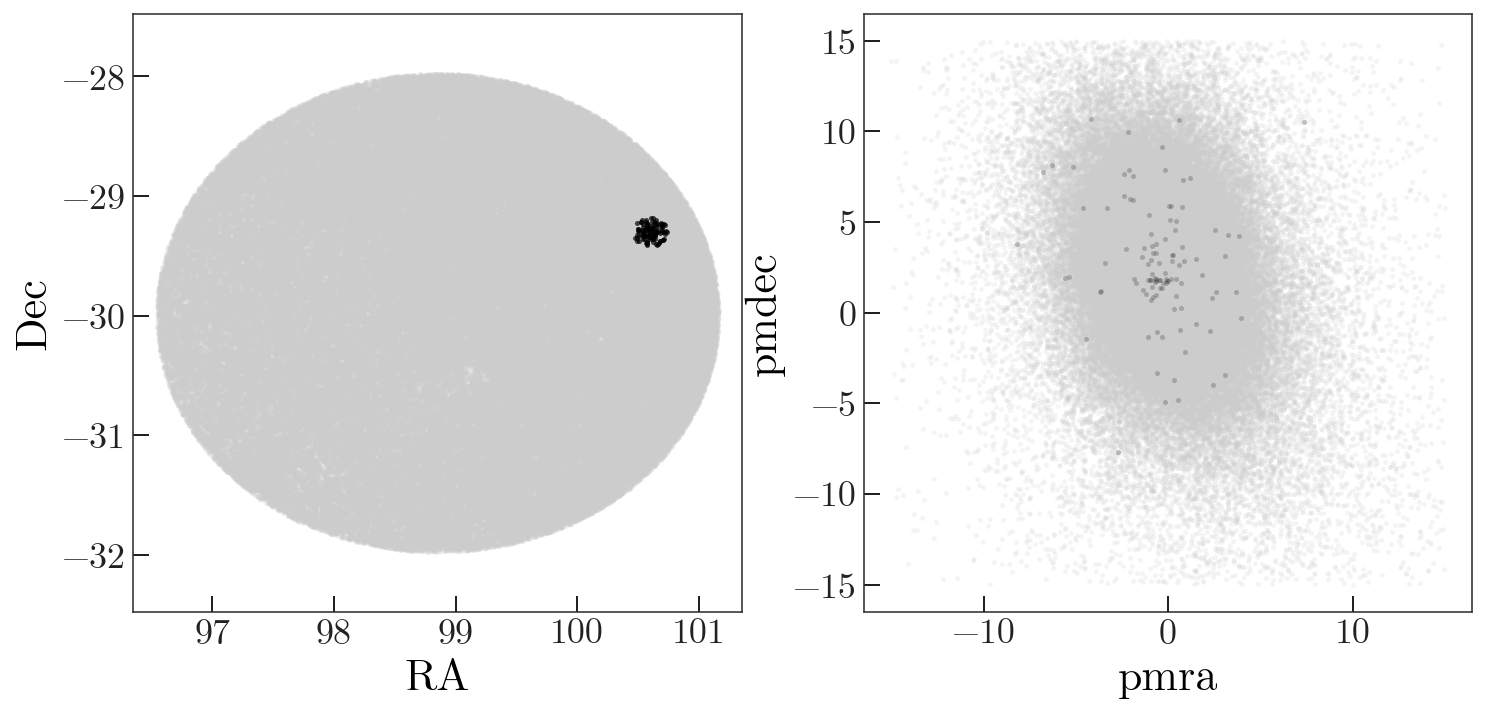

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].plot(group.ra, group.dec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[0].plot(group.ra[derp_mask&cmd_mask], group.dec[derp_mask&cmd_mask], 
             marker='.', alpha=0.7, color='k', linestyle='none')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
axes[0].set_xlim(_x - 2.5, _x + 2.5)
axes[0].set_ylim(_y - 2.5, _y + 2.5)
# axes[0].set_xlim(100, _x + 2)
# axes[0].set_ylim(-30, -28.5)
axes[0].scatter(gals_c.ra.degree, gals_c.dec.degree)

axes[1].plot(group.pmra, group.pmdec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[1].plot(group.pmra[derp_mask&cmd_mask], group.pmdec[derp_mask&cmd_mask], 
             marker='.', alpha=0.2, color='k', linestyle='none')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

---

### Magellanic Leading Stream star-formation

https://arxiv.org/pdf/1511.05853.pdf
http://iopscience.iop.org/article/10.1086/587042/pdf

In [31]:
pmra = np.mean(c[cls_to_idx2[1]].pm_ra_cosdec)
pmdec = np.mean(c[cls_to_idx2[1]].pm_dec)

In [32]:
g2 = GaiaData('../data/mag-leading-stream.fits')

In [98]:
pm_mask2 = np.sqrt((g2.pmra - pmra)**2 + (g2.pmdec - pmdec)**2) < 0.75*u.mas/u.yr

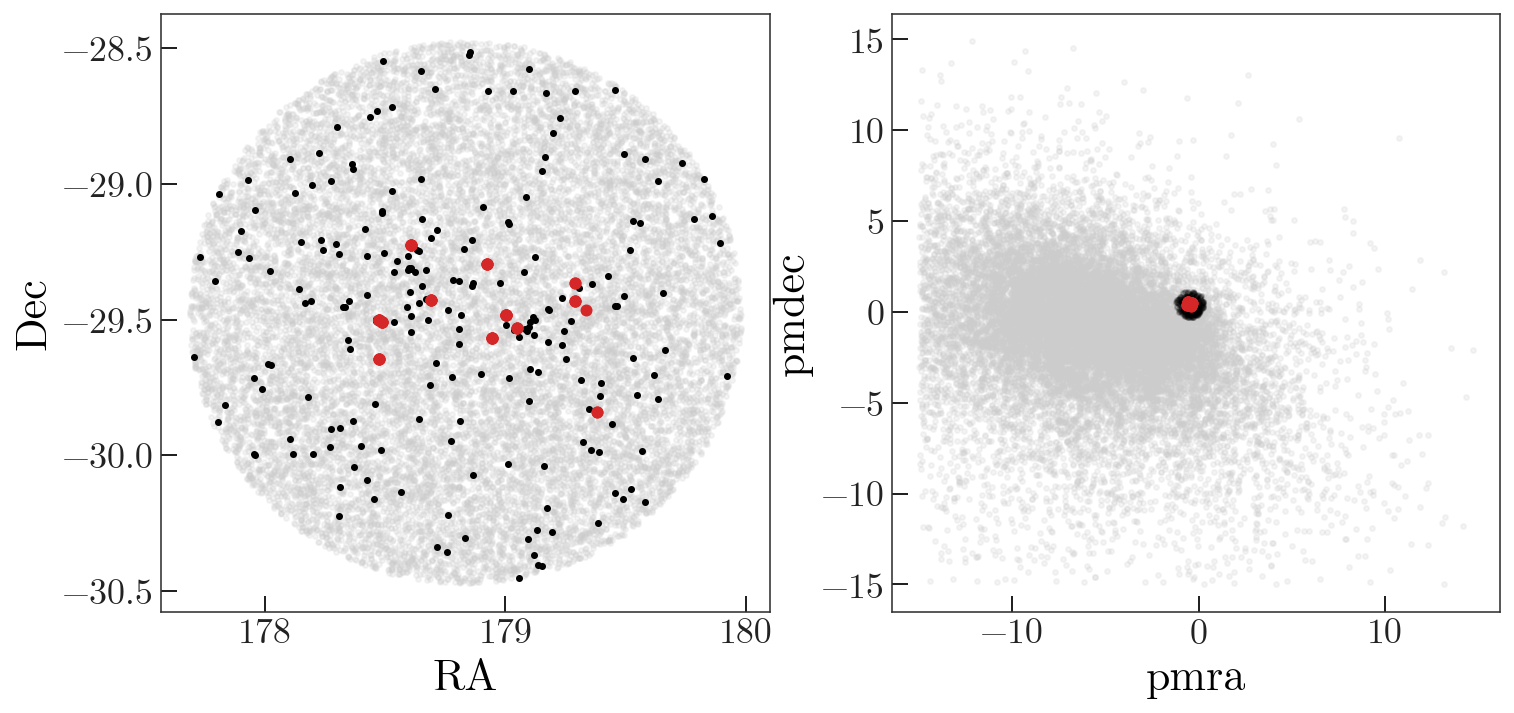

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].scatter(g2.ra, g2.dec, marker='.', alpha=0.2, color='#cccccc')
axes[0].scatter(g2.ra[pm_mask2], g2.dec[pm_mask2], marker='.', alpha=1., color='k')
axes[0].scatter(c[cls_to_idx2[1]].ra, c[cls_to_idx2[1]].dec, marker='o', color='tab:red')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')

axes[1].scatter(g2.pmra, g2.pmdec, marker='.', alpha=0.2, color='#cccccc')
axes[1].scatter(g2.pmra[pm_mask2], g2.pmdec[pm_mask2], marker='.', alpha=0.2, color='k')
axes[1].scatter(c[cls_to_idx2[1]].pm_ra_cosdec, c[cls_to_idx2[1]].pm_dec, marker='o', color='tab:red')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

fig.savefig('sky_pm.png', dpi=250)

In [115]:
(np.mean(c[cls_to_idx2[1]].pm_ra_cosdec),
 np.mean(c[cls_to_idx2[1]].pm_dec))

(<Quantity -0.4777795 mas / yr>, <Quantity 0.44950373 mas / yr>)

In [53]:
(np.mean(c[cls_to_idx2[1]].galactic.l.degree),
 np.mean(c[cls_to_idx2[1]].galactic.b.degree))

(288.5526812437784, 31.826496040509596)

In [71]:
g3 = GaiaData('/Users/adrian/Downloads/1525908601756O-result.fits')

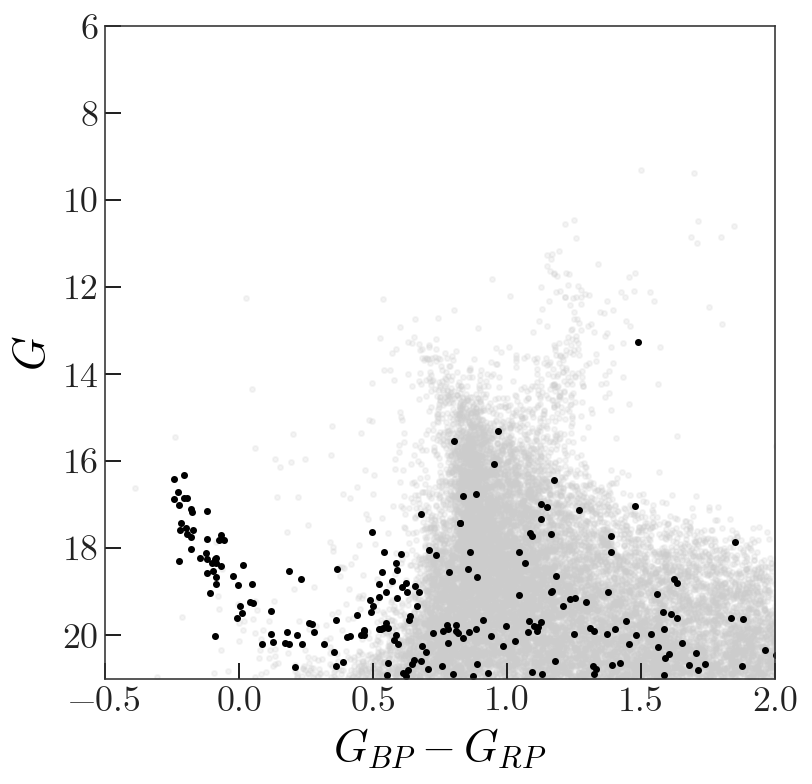

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(g2.bp_rp, g2.phot_g_mean_mag, marker='.', alpha=0.2, color='#cccccc')
ax.scatter(g2.bp_rp[pm_mask2], g2.phot_g_mean_mag[pm_mask2], marker='.', alpha=1., color='k')

# ax.scatter(g3.bp_rp, g3.phot_g_mean_mag, marker='.', alpha=1)

ax.set_xlim(-0.5, 2.)
ax.set_ylim(21, 6)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$G$')

fig.savefig('cmd.png', dpi=250)

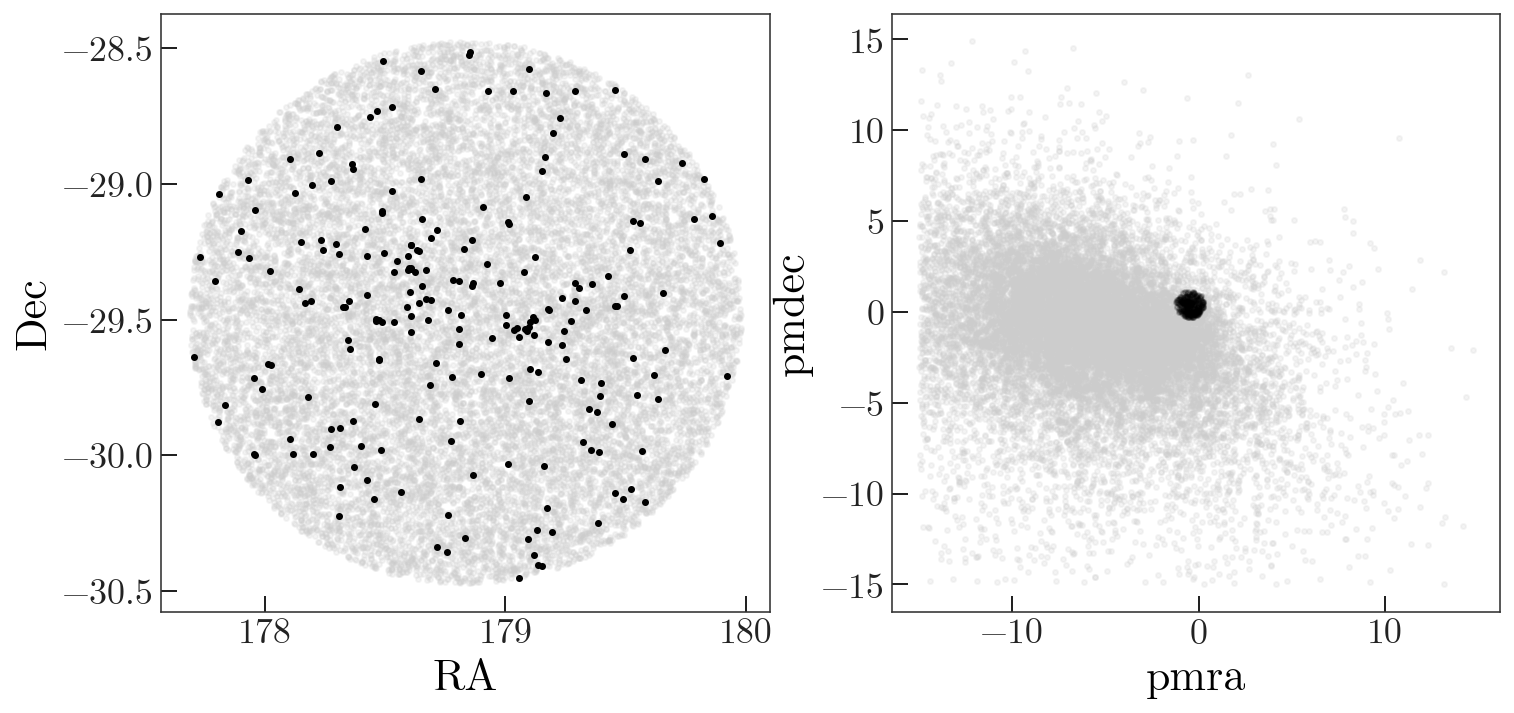

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].scatter(g2.ra, g2.dec, marker='.', alpha=0.2, color='#cccccc')
axes[0].scatter(g2.ra[pm_mask2], g2.dec[pm_mask2], marker='.', alpha=1., color='k')
# axes[0].scatter(g3.ra, g3.dec, marker='.', alpha=0.2, color='#cccccc')
# axes[0].scatter(g3.ra[pm_mask3], g3.dec[pm_mask3], marker='.', alpha=1., color='k')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')

axes[1].scatter(g2.pmra, g2.pmdec, marker='.', alpha=0.2, color='#cccccc')
axes[1].scatter(g2.pmra[pm_mask2], g2.pmdec[pm_mask2], marker='.', alpha=0.2, color='k')
# axes[1].scatter(g3.pmra, g3.pmdec, marker='.', alpha=0.2, color='#cccccc')
# axes[1].scatter(g3.pmra[pm_mask3], g3.pmdec[pm_mask3], marker='.', alpha=0.8, color='k')
axes[1].scatter(c[cls_to_idx2[1]].pm_ra_cosdec, c[cls_to_idx2[1]].pm_dec, marker='o', color='tab:red')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

fig.savefig('sky_pm.png', dpi=250)

In [116]:
wtf = coord.SkyCoord(ra=g2.ra[pm_mask2],
                     dec=g2.dec[pm_mask2])

In [117]:
import gala.coordinates as gc

In [119]:
mag = wtf.transform_to(gc.MagellanicStream)

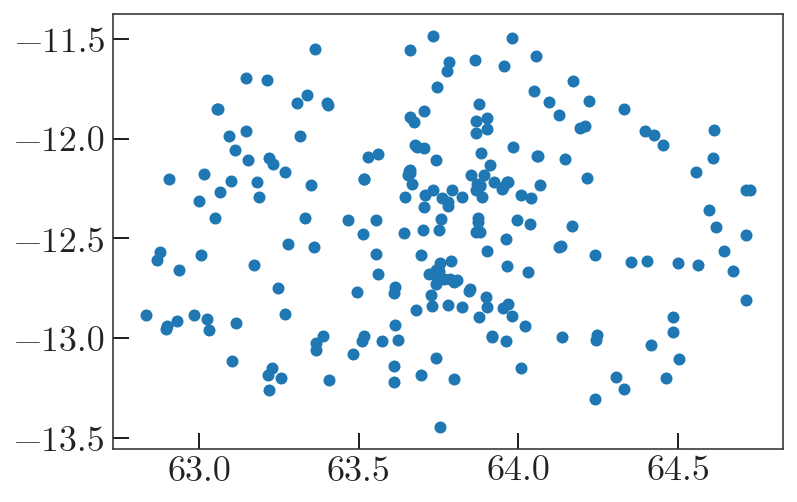

In [120]:
plt.scatter(mag.L.degree, mag.B.degree)